# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [258]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body

In [259]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [260]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [261]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [262]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [263]:
@time gops, ops = NavierStokes.set_operators_body!(dom,params);

### Create an initial solution structure

In [264]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


### Advance the solution

In [265]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

6.805594 seconds (2.18 M allocations: 1.186 GiB, 4.70% gc time)
  

Solution: t = 1.0000000000000007


In [266]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);

8.283306 seconds (1.33 M allocations: 2.114 GiB, 6.82% gc time)
  

In [278]:
t = [copy(f[i].t) for i = 1:length(f)];
@time ux = [copy(f[i].ux) for i = 1:length(f)];

  0.046060 seconds (16.95 k allocations: 16.102 MiB)


In [268]:
spts = Process.SamplePoint(1.5,1.5)

Whirl2d.Process.SamplePoints([1.5], [1.5])

In [279]:
x = Grids.xfacex(dom.grid)
y = Grids.yfacex(dom.grid)
uxsamp = Process.sample(spts,ux,x,y)

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0144011, 0.0147398, 0.0150096, 0.0152371, 0.0154388, 0.0156248, 0.0158013, 0.0159724, 0.0161409  …  0.0426251, 0.0431246, 0.0436275, 0.0441339, 0.0446436, 0.0451566, 0.0456728, 0.0461922, 0.0467147, 0.0472403]

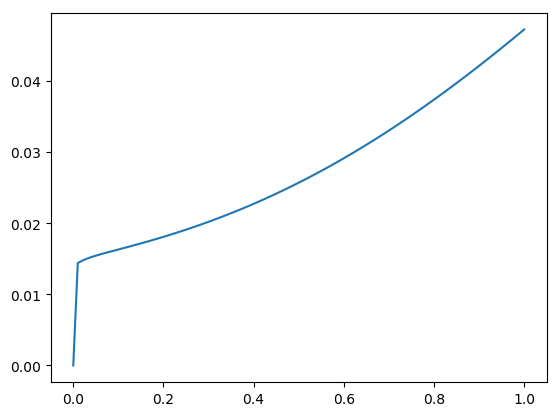

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32ef75190>

In [280]:
plot(t,uxsamp[1])

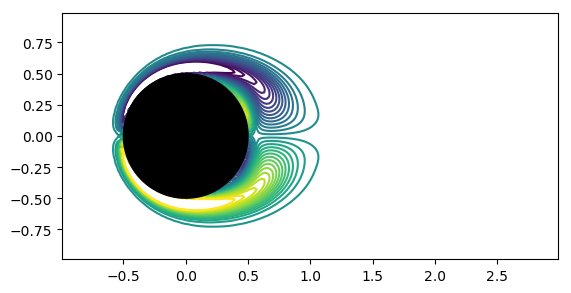

(-0.99, 2.99, -0.99, 0.99)

In [227]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(f[end].ω),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

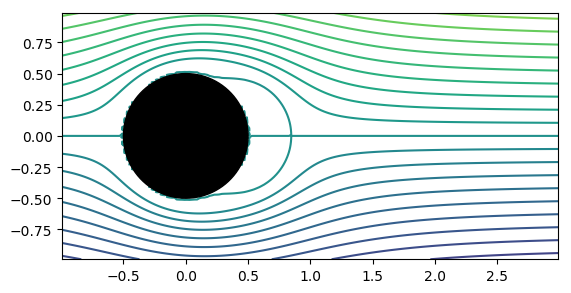

(-0.99, 2.99, -0.99, 0.99)

In [231]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,y.+transpose(f[end].ψ),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

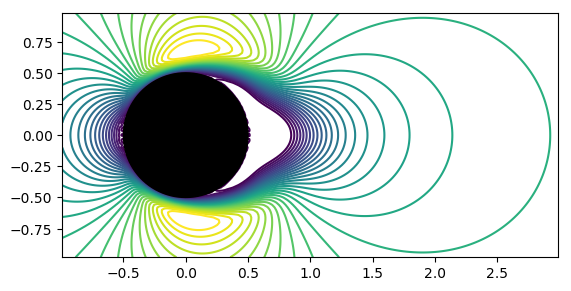

(-0.99, 2.99, -0.98, 0.98)

In [234]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(f[end].ux).+1,linspace(0,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")